In [1]:
## 引入头文件
import cv2
import numpy as np
from skimage import filters, feature, img_as_float, measure, morphology
import os
import matplotlib.pyplot as plt
from skimage.feature import shape_index
from skimage.draw import circle
from skimage.filters import try_all_threshold
from skimage.segmentation import chan_vese
from skimage.filters import threshold_otsu, threshold_triangle

In [2]:
## 定义路径
# 将path定义为图片文件夹的路径
path = r'C:\Users\Kfor\Desktop\亚太\2019 APMCM Problems\2019 APMCM Problems\InnerArea'
os.chdir(path)

In [26]:
import numpy as np
import scipy.ndimage as ndi
from scipy.ndimage import generate_binary_structure, binary_erosion, label
from skimage.filters import gaussian, threshold_otsu
from skimage import dtype_limits, img_as_float

def check_nD(array, ndim, arg_name='image'):
    
    array = np.asanyarray(array)
    msg_incorrect_dim = "The parameter `%s` must be a %s-dimensional array"
    msg_empty_array = "The parameter `%s` cannot be an empty array"
    if isinstance(ndim, int):
        ndim = [ndim]
    if array.size == 0:
        raise ValueError(msg_empty_array % (arg_name))
    if not array.ndim in ndim:
        raise ValueError(msg_incorrect_dim % (arg_name, '-or-'.join([str(n) for n in ndim])))


#     if mask is None:
#         mask = np.ones(image.shape, dtype=bool)

#     def fsmooth(x):
# #         sigma = np.zeros(shape=np.shape(x))
# #         calTmp = np.zeros(shape=np.shape(x))
# #         row, col = x.shape
# #         for i in range(row):
# #             for j in range(col):
# #                 if (i==0 or i==row-1 or j==0 or j==col-1):
# #                     calTmp[i][j] = x[i][j]
# #                 else:
# #                     calTmp[i][j] = np.sum(x[i-1:i+2,j-1:j+2])
# #         sigma = np.abs(image - calTmp)
# #         print('tmp',x.shape,sigma.shape)
#         return img_as_float(gaussian(x, sigma, mode='constant'))

def smooth_with_function_and_mask(image, function, mask):
    """Smooth an image with a linear function, ignoring masked pixels.
    Parameters
    ----------
    image : array
        Image you want to smooth.
    function : callable
        A function that does image smoothing.
    mask : array
        Mask with 1's for significant pixels, 0's for masked pixels.
    Notes
    ------
    This function calculates the fractional contribution of masked pixels
    by applying the function to the mask (which gets you the fraction of
    the pixel data that's due to significant points). We then mask the image
    and apply the function. The resulting values will be lower by the
    bleed-over fraction, so you can recalibrate by dividing by the function
    on the mask to recover the effect of smoothing from just the significant
    pixels.
    """
    bleed_over = function(mask.astype(float))
    masked_image = np.zeros(image.shape, image.dtype)
    masked_image[mask] = image[mask]
    smoothed_image = function(masked_image)
    output_image = smoothed_image / (bleed_over + np.finfo(float).eps)
    return output_image


def improveCanny(image, sigma=1., low_threshold=None, high_threshold=None, mask=None,
          use_quantiles=False):
    check_nD(image, 2)
    dtype_max = dtype_limits(image, clip_negative=False)[1]

    if low_threshold is None:
        low_threshold = 0.1
    else:
        low_threshold = low_threshold / dtype_max

    if high_threshold is None:
        high_threshold = 0.2
    else:
        high_threshold = high_threshold / dtype_max

    if mask is None:
        mask = np.ones(image.shape, dtype=bool)

    def fsmooth(x):
        return img_as_float(gaussian(x, sigma, mode='constant'))

    smoothed = smooth_with_function_and_mask(image, fsmooth, mask)
    jsobel = ndi.sobel(smoothed, axis=1)
    isobel = ndi.sobel(smoothed, axis=0)
    abs_isobel = np.abs(isobel)
    abs_jsobel = np.abs(jsobel)
    magnitude = np.hypot(isobel, jsobel)

    #
    # Make the eroded mask. Setting the border value to zero will wipe
    # out the image edges for us.
    #
    s = generate_binary_structure(2, 2)
    eroded_mask = binary_erosion(mask, s, border_value=0)
    eroded_mask = eroded_mask & (magnitude > 0)
    #
    #--------- Find local maxima --------------
    #
    # Assign each point to have a normal of 0-45 degrees, 45-90 degrees,
    # 90-135 degrees and 135-180 degrees.
    #
    local_maxima = np.zeros(image.shape, bool)
    #----- 0 to 45 degrees ------
    pts_plus = (isobel >= 0) & (jsobel >= 0) & (abs_isobel >= abs_jsobel)
    pts_minus = (isobel <= 0) & (jsobel <= 0) & (abs_isobel >= abs_jsobel)
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    # Get the magnitudes shifted left to make a matrix of the points to the
    # right of pts. Similarly, shift left and down to get the points to the
    # top right of pts.
    c1 = magnitude[1:, :][pts[:-1, :]]
    c2 = magnitude[1:, 1:][pts[:-1, :-1]]
    m = magnitude[pts]
    w = abs_jsobel[pts] / abs_isobel[pts]
    c_plus = c2 * w + c1 * (1 - w) <= m
    c1 = magnitude[:-1, :][pts[1:, :]]
    c2 = magnitude[:-1, :-1][pts[1:, 1:]]
    c_minus = c2 * w + c1 * (1 - w) <= m
    local_maxima[pts] = c_plus & c_minus
    #----- 45 to 90 degrees ------
    # Mix diagonal and vertical
    #
    pts_plus = (isobel >= 0) & (jsobel >= 0) & (abs_isobel <= abs_jsobel)
    pts_minus = (isobel <= 0) & (jsobel <= 0) & (abs_isobel <= abs_jsobel)
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    c1 = magnitude[:, 1:][pts[:, :-1]]
    c2 = magnitude[1:, 1:][pts[:-1, :-1]]
    m = magnitude[pts]
    w = abs_isobel[pts] / abs_jsobel[pts]
    c_plus = c2 * w + c1 * (1 - w) <= m
    c1 = magnitude[:, :-1][pts[:, 1:]]
    c2 = magnitude[:-1, :-1][pts[1:, 1:]]
    c_minus = c2 * w + c1 * (1 - w) <= m
    local_maxima[pts] = c_plus & c_minus
    #----- 90 to 135 degrees ------
    # Mix anti-diagonal and vertical
    #
    pts_plus = (isobel <= 0) & (jsobel >= 0) & (abs_isobel <= abs_jsobel)
    pts_minus = (isobel >= 0) & (jsobel <= 0) & (abs_isobel <= abs_jsobel)
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    c1a = magnitude[:, 1:][pts[:, :-1]]
    c2a = magnitude[:-1, 1:][pts[1:, :-1]]
    m = magnitude[pts]
    w = abs_isobel[pts] / abs_jsobel[pts]
    c_plus = c2a * w + c1a * (1.0 - w) <= m
    c1 = magnitude[:, :-1][pts[:, 1:]]
    c2 = magnitude[1:, :-1][pts[:-1, 1:]]
    c_minus = c2 * w + c1 * (1.0 - w) <= m
    local_maxima[pts] = c_plus & c_minus
    #----- 135 to 180 degrees ------
    # Mix anti-diagonal and anti-horizontal
    #
    pts_plus = (isobel <= 0) & (jsobel >= 0) & (abs_isobel >= abs_jsobel)
    pts_minus = (isobel >= 0) & (jsobel <= 0) & (abs_isobel >= abs_jsobel)
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    c1 = magnitude[:-1, :][pts[1:, :]]
    c2 = magnitude[:-1, 1:][pts[1:, :-1]]
    m = magnitude[pts]
    w = abs_jsobel[pts] / abs_isobel[pts]
    c_plus = c2 * w + c1 * (1 - w) <= m
    c1 = magnitude[1:, :][pts[:-1, :]]
    c2 = magnitude[1:, :-1][pts[:-1, 1:]]
    c_minus = c2 * w + c1 * (1 - w) <= m
    local_maxima[pts] = c_plus & c_minus

    #
    #---- If use_quantiles is set then calculate the thresholds to use
    #
    if use_quantiles:
        if high_threshold > 1.0 or low_threshold > 1.0:
            raise ValueError("Quantile thresholds must not be > 1.0")
        if high_threshold < 0.0 or low_threshold < 0.0:
            raise ValueError("Quantile thresholds must not be < 0.0")

        high_threshold = np.percentile(magnitude, 100.0 * high_threshold)
        low_threshold = np.percentile(magnitude, 100.0 * low_threshold)

        
        
    threshForOtsu = threshold_otsu(magnitude)
    high_threshold = threshForOtsu
    low_threshold = 0.5 * high_threshold
    
    #
    #---- Create two masks at the two thresholds.
    #
    high_mask = local_maxima & (magnitude >= high_threshold)
    low_mask = local_maxima & (magnitude >= low_threshold)

    
    #
    # Segment the low-mask, then only keep low-segments that have
    # some high_mask component in them
    #
    strel = np.ones((3, 3), bool)
    labels, count = label(low_mask, strel)
    if count == 0:
        return low_mask

    sums = (np.array(ndi.sum(high_mask, labels,
                             np.arange(count, dtype=np.int32) + 1),
                     copy=False, ndmin=1))
    good_label = np.zeros((count + 1,), bool)
    good_label[1:] = sums > 0
    output_mask = good_label[labels]
    return output_mask

In [27]:

def testCanny(image, sigma=1., low_threshold=None, high_threshold=None, mask=None,
          use_quantiles=False):
    """Edge filter an image using the Canny algorithm.
    Parameters
    -----------
    image : 2D array
        Grayscale input image to detect edges on; can be of any dtype.
    sigma : float, optional
        Standard deviation of the Gaussian filter.
    low_threshold : float, optional
        Lower bound for hysteresis thresholding (linking edges).
        If None, low_threshold is set to 10% of dtype's max.
    high_threshold : float, optional
        Upper bound for hysteresis thresholding (linking edges).
        If None, high_threshold is set to 20% of dtype's max.
    mask : array, dtype=bool, optional
        Mask to limit the application of Canny to a certain area.
    use_quantiles : bool, optional
        If True then treat low_threshold and high_threshold as quantiles of the
        edge magnitude image, rather than absolute edge magnitude values. If True
        then the thresholds must be in the range [0, 1].
    Returns
    -------
    output : 2D array (image)
        The binary edge map.
    See also
    --------
    skimage.sobel
    Notes
    -----
    The steps of the algorithm are as follows:
    * Smooth the image using a Gaussian with ``sigma`` width.
    * Apply the horizontal and vertical Sobel operators to get the gradients
      within the image. The edge strength is the norm of the gradient.
    * Thin potential edges to 1-pixel wide curves. First, find the normal
      to the edge at each point. This is done by looking at the
      signs and the relative magnitude of the X-Sobel and Y-Sobel
      to sort the points into 4 categories: horizontal, vertical,
      diagonal and antidiagonal. Then look in the normal and reverse
      directions to see if the values in either of those directions are
      greater than the point in question. Use interpolation to get a mix of
      points instead of picking the one that's the closest to the normal.
    * Perform a hysteresis thresholding: first label all points above the
      high threshold as edges. Then recursively label any point above the
      low threshold that is 8-connected to a labeled point as an edge.
    References
    -----------
    .. [1] Canny, J., A Computational Approach To Edge Detection, IEEE Trans.
           Pattern Analysis and Machine Intelligence, 8:679-714, 1986
           :DOI:`10.1109/TPAMI.1986.4767851`
    .. [2] William Green's Canny tutorial
           http://dasl.unlv.edu/daslDrexel/alumni/bGreen/www.pages.drexel.edu/_weg22/can_tut.html
    Examples
    --------
    >>> from skimage import feature
    >>> # Generate noisy image of a square
    >>> im = np.zeros((256, 256))
    >>> im[64:-64, 64:-64] = 1
    >>> im += 0.2 * np.random.rand(*im.shape)
    >>> # First trial with the Canny filter, with the default smoothing
    >>> edges1 = feature.canny(im)
    >>> # Increase the smoothing for better results
    >>> edges2 = feature.canny(im, sigma=3)
    """

    #
    # The steps involved:
    #
    # * Smooth using the Gaussian with sigma above.
    #
    # * Apply the horizontal and vertical Sobel operators to get the gradients
    #   within the image. The edge strength is the sum of the magnitudes
    #   of the gradients in each direction.
    #
    # * Find the normal to the edge at each point using the arctangent of the
    #   ratio of the Y sobel over the X sobel - pragmatically, we can
    #   look at the signs of X and Y and the relative magnitude of X vs Y
    #   to sort the points into 4 categories: horizontal, vertical,
    #   diagonal and antidiagonal.
    #
    # * Look in the normal and reverse directions to see if the values
    #   in either of those directions are greater than the point in question.
    #   Use interpolation to get a mix of points instead of picking the one
    #   that's the closest to the normal.
    #
    # * Label all points above the high threshold as edges.
    # * Recursively label any point above the low threshold that is 8-connected
    #   to a labeled point as an edge.
    #
    # Regarding masks, any point touching a masked point will have a gradient
    # that is "infected" by the masked point, so it's enough to erode the
    # mask by one and then mask the output. We also mask out the border points
    # because who knows what lies beyond the edge of the image?
    #
    check_nD(image, 2)
    dtype_max = dtype_limits(image, clip_negative=False)[1]

    if low_threshold is None:
        low_threshold = 0.1
    else:
        low_threshold = low_threshold / dtype_max

    if high_threshold is None:
        high_threshold = 0.2
    else:
        high_threshold = high_threshold / dtype_max

    if mask is None:
        mask = np.ones(image.shape, dtype=bool)

    def fsmooth(x):
        return img_as_float(gaussian(x, sigma, mode='constant'))

    smoothed = smooth_with_function_and_mask(image, fsmooth, mask)
    jsobel = ndi.sobel(smoothed, axis=1)
    isobel = ndi.sobel(smoothed, axis=0)
    abs_isobel = np.abs(isobel)
    abs_jsobel = np.abs(jsobel)
    magnitude = np.hypot(isobel, jsobel)

    #
    # Make the eroded mask. Setting the border value to zero will wipe
    # out the image edges for us.
    #
    s = generate_binary_structure(2, 2)
    eroded_mask = binary_erosion(mask, s, border_value=0)
    eroded_mask = eroded_mask & (magnitude > 0)
    #
    #--------- Find local maxima --------------
    #
    # Assign each point to have a normal of 0-45 degrees, 45-90 degrees,
    # 90-135 degrees and 135-180 degrees.
    #
    local_maxima = np.zeros(image.shape, bool)
    #----- 0 to 45 degrees ------
    pts_plus = (isobel >= 0) & (jsobel >= 0) & (abs_isobel >= abs_jsobel)
    pts_minus = (isobel <= 0) & (jsobel <= 0) & (abs_isobel >= abs_jsobel)
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    # Get the magnitudes shifted left to make a matrix of the points to the
    # right of pts. Similarly, shift left and down to get the points to the
    # top right of pts.
    c1 = magnitude[1:, :][pts[:-1, :]]
    c2 = magnitude[1:, 1:][pts[:-1, :-1]]
    m = magnitude[pts]
    w = abs_jsobel[pts] / abs_isobel[pts]
    c_plus = c2 * w + c1 * (1 - w) <= m
    c1 = magnitude[:-1, :][pts[1:, :]]
    c2 = magnitude[:-1, :-1][pts[1:, 1:]]
    c_minus = c2 * w + c1 * (1 - w) <= m
    local_maxima[pts] = c_plus & c_minus
    #----- 45 to 90 degrees ------
    # Mix diagonal and vertical
    #
    pts_plus = (isobel >= 0) & (jsobel >= 0) & (abs_isobel <= abs_jsobel)
    pts_minus = (isobel <= 0) & (jsobel <= 0) & (abs_isobel <= abs_jsobel)
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    c1 = magnitude[:, 1:][pts[:, :-1]]
    c2 = magnitude[1:, 1:][pts[:-1, :-1]]
    m = magnitude[pts]
    w = abs_isobel[pts] / abs_jsobel[pts]
    c_plus = c2 * w + c1 * (1 - w) <= m
    c1 = magnitude[:, :-1][pts[:, 1:]]
    c2 = magnitude[:-1, :-1][pts[1:, 1:]]
    c_minus = c2 * w + c1 * (1 - w) <= m
    local_maxima[pts] = c_plus & c_minus
    #----- 90 to 135 degrees ------
    # Mix anti-diagonal and vertical
    #
    pts_plus = (isobel <= 0) & (jsobel >= 0) & (abs_isobel <= abs_jsobel)
    pts_minus = (isobel >= 0) & (jsobel <= 0) & (abs_isobel <= abs_jsobel)
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    c1a = magnitude[:, 1:][pts[:, :-1]]
    c2a = magnitude[:-1, 1:][pts[1:, :-1]]
    m = magnitude[pts]
    w = abs_isobel[pts] / abs_jsobel[pts]
    c_plus = c2a * w + c1a * (1.0 - w) <= m
    c1 = magnitude[:, :-1][pts[:, 1:]]
    c2 = magnitude[1:, :-1][pts[:-1, 1:]]
    c_minus = c2 * w + c1 * (1.0 - w) <= m
    local_maxima[pts] = c_plus & c_minus
    #----- 135 to 180 degrees ------
    # Mix anti-diagonal and anti-horizontal
    #
    pts_plus = (isobel <= 0) & (jsobel >= 0) & (abs_isobel >= abs_jsobel)
    pts_minus = (isobel >= 0) & (jsobel <= 0) & (abs_isobel >= abs_jsobel)
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    c1 = magnitude[:-1, :][pts[1:, :]]
    c2 = magnitude[:-1, 1:][pts[1:, :-1]]
    m = magnitude[pts]
    w = abs_jsobel[pts] / abs_isobel[pts]
    c_plus = c2 * w + c1 * (1 - w) <= m
    c1 = magnitude[1:, :][pts[:-1, :]]
    c2 = magnitude[1:, :-1][pts[:-1, 1:]]
    c_minus = c2 * w + c1 * (1 - w) <= m
    local_maxima[pts] = c_plus & c_minus

    #
    #---- If use_quantiles is set then calculate the thresholds to use
    #
    if use_quantiles:
        if high_threshold > 1.0 or low_threshold > 1.0:
            raise ValueError("Quantile thresholds must not be > 1.0")
        if high_threshold < 0.0 or low_threshold < 0.0:
            raise ValueError("Quantile thresholds must not be < 0.0")

        high_threshold = np.percentile(magnitude, 100.0 * high_threshold)
        low_threshold = np.percentile(magnitude, 100.0 * low_threshold)

    #
    #---- Create two masks at the two thresholds.
    #
    high_mask = local_maxima & (magnitude >= high_threshold)
    low_mask = local_maxima & (magnitude >= low_threshold)

    #
    # Segment the low-mask, then only keep low-segments that have
    # some high_mask component in them
    #
    strel = np.ones((3, 3), bool)
    labels, count = label(low_mask, strel)
    if count == 0:
        return low_mask

    sums = (np.array(ndi.sum(high_mask, labels,
                             np.arange(count, dtype=np.int32) + 1),
                     copy=False, ndmin=1))
    good_label = np.zeros((count + 1,), bool)
    good_label[1:] = sums > 0
    output_mask = good_label[labels]
    return output_mask

0.05456723986211012 0.02728361993105506


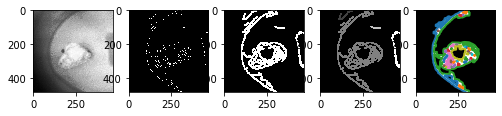

In [4]:
## 用于验证边缘检测算法

os.chdir('../InnerArea')

# 读取图像（测试）
imageTest = cv2.imread("0515.bmp", cv2.IMREAD_GRAYSCALE)

# 创建画布
plt.figure(figsize=(10,60))
# 直方图均值化并显示原图
plt.subplot(1,6,1)
plt.imshow(imageTest,cmap=plt.cm.gray)

# canny边缘检测
ed1 = improveCanny(imageTest,sigma=3)

# 让边缘标白，其余为黑
tmp = np.ndarray(shape=np.shape(ed1))
tmp[ed1] = 255

# 区域生长
kernel = np.ones((5,5),np.uint8)
tmp = cv2.dilate(tmp, kernel, iterations=2)



# 标记连通区域
result,labels = measure.label(tmp,return_num=True)
props = measure.regionprops(result)
numPix = []
for ia in range(len(props)):
    numPix += [props[ia].area]
maxnum = max(numPix)
index = numPix.index(maxnum)
rr = result == index+1



def findMaxLabelArea(image):
    # 标记连通区域
    result,labels = measure.label(image,return_num=True)
    props = measure.regionprops(result)
    numPix = []
    for ia in range(len(props)):
        numPix += [props[ia].area]
    maxnum = max(numPix)
    index = numPix.index(maxnum)
    rr = result == index+1
    return rr,result


# 画出边缘
contours = measure.find_contours(rr,0.5)

plt.subplot(1,6,2)
plt.imshow(ed1,cmap=plt.cm.gray)
plt.subplot(1,6,3)
plt.imshow(tmp,cmap=plt.cm.gray)
plt.subplot(1,6,4)
plt.imshow(result,cmap=plt.cm.gray)
plt.subplot(1,6,5)
plt.imshow(rr,cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

# plt.subplot(1,6,6)
# rrr = morphology.flood_fill(rr,(250,250),255)
# plt.imshow(rrr,cmap=plt.cm.gray)

# 至此得出，sigma选择2.25效果较好

0.07079332505284937
0.0649501566902893
0.05902901652947093
0.09410255767201814
0.08585615950171914
0.07678958216778214
0.07629129501145165
0.06987027242640267
0.06311420737368173
0.07361142138291746
0.0673125801828039
0.060427057177102284
0.08460796598280226
0.07456428897015156
0.06825775542126891
0.06139458872766675
0.05639882991885421
0.052095519303829094
0.06492937091816384
0.05915991427880217
0.05456723986211012
0.06198653452895682
0.05694463450645633
0.05135189904787747
0.046263344377427545
0.043450491995443055
0.04109468994583418
0.06627073061841646
0.05884626237642786
0.05484516210742863
0.0746514447093008
0.06604164730852721
0.05983469464341047
0.07684253547751263
0.0670838107569402
0.06051882282164456
0.07501450231953587
0.06696706482821899
0.05862383901685703
0.06768601029445986
0.06081056171458679
0.055612019900008275
0.07303547028705165
0.06613765777832478
0.060328182456328455
0.07653265430886537
0.0676602271849729
0.061295444879693343
0.08450320041818685
0.0758941889142746

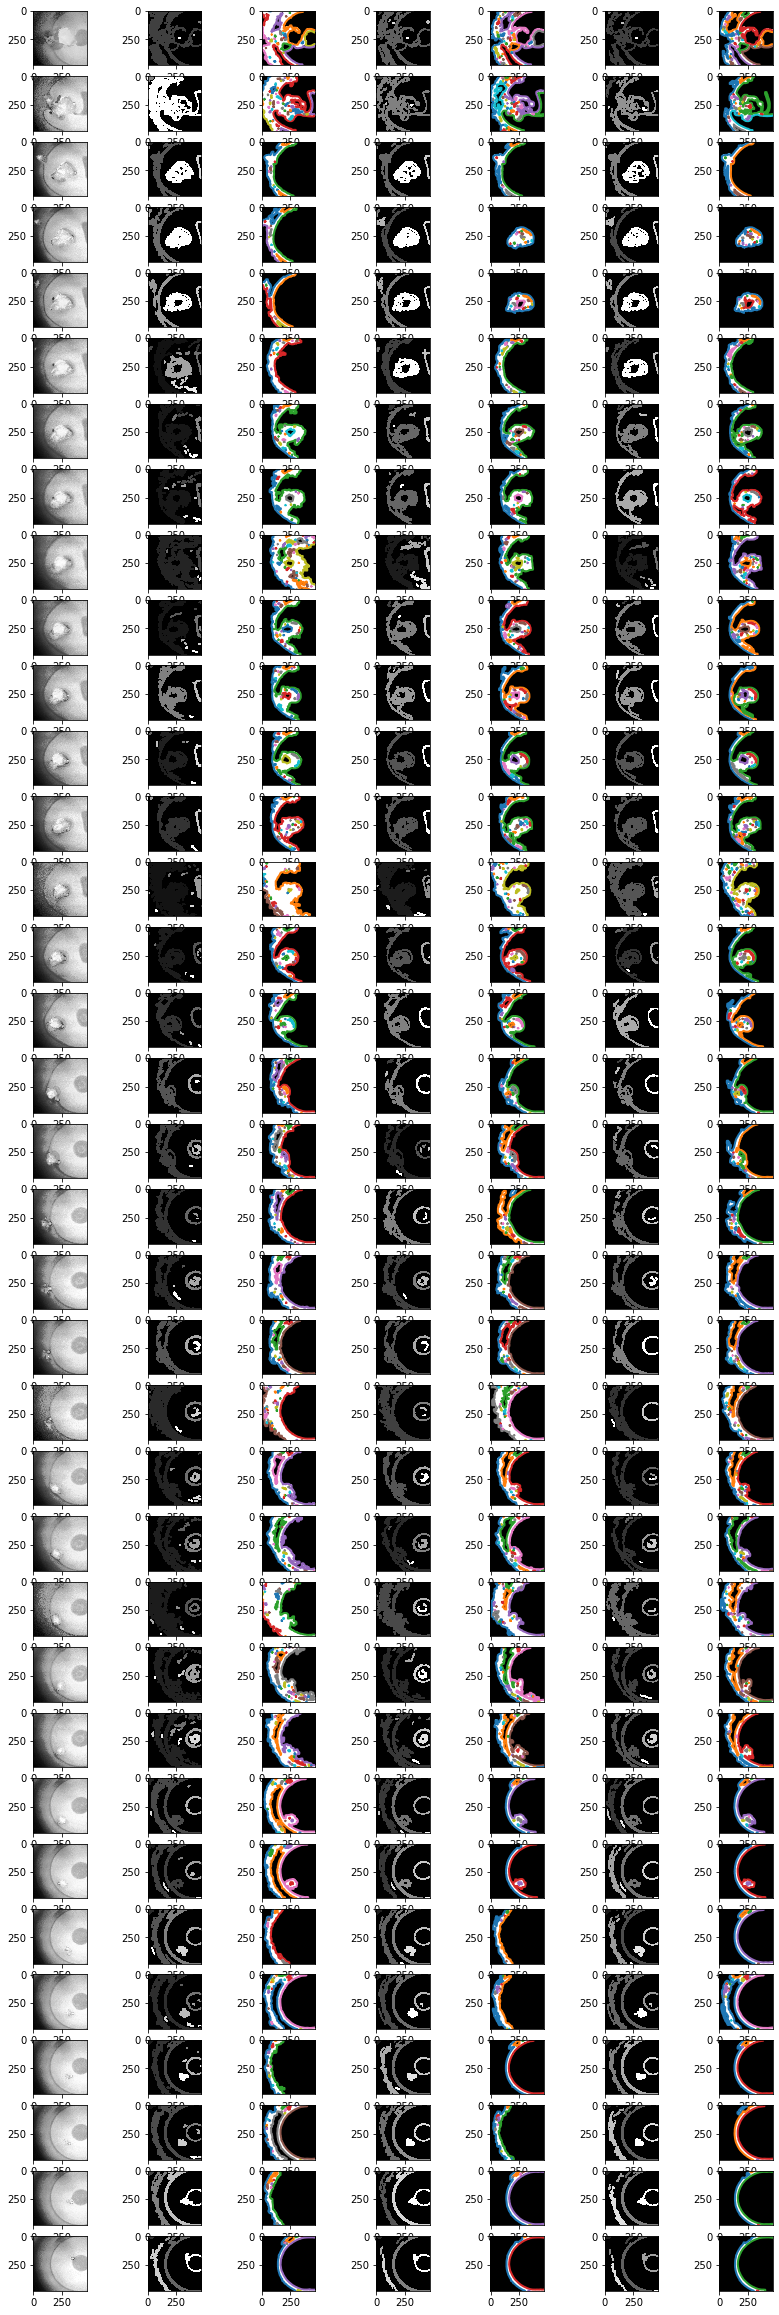

In [74]:
plt.figure(figsize=(14,60))
for i,name in enumerate(range(497,600,3)):
    image = cv2.imread('0'+str(name)+'.bmp', cv2.IMREAD_GRAYSCALE)
    plt.subplot(50,7,i*7+1)
    plt.imshow(image,cmap=plt.cm.gray)
    
    for index,sigmaTmp in enumerate([2,2.5,3]):

        # canny边缘检测
        ed = improveCanny(image,sigma=sigmaTmp)
        # 让边缘标白，其余为黑
        tmp = np.ndarray(shape=np.shape(ed))
        tmp[ed] = 255
        # 区域生长
        kernel = np.ones((5,5),np.uint8)
        tmp = cv2.dilate(tmp, kernel, iterations=3)
        try:
            rr,result = findMaxLabelArea(tmp)
        except:
            print(name)
        # 画出边缘
        contours = measure.find_contours(rr,0.5)
        
        plt.subplot(50,7,i*7+2+index*2)
        plt.imshow(result,cmap=plt.cm.gray)
        plt.subplot(50,7,i*7+3+index*2)
        plt.imshow(rr,cmap=plt.cm.gray)

        
        for n, contour in enumerate(contours):
            plt.plot(contour[:, 1], contour[:, 0], linewidth=2)


In [5]:
os.chdir('../InnerArea')
imageProp = [(0, 1),(0, 1),(0, 1),(0, 1),(0, 1), (1,-3),(1,-3),(1,-2),(1,-1),(1,-2),# 9, name+3 == index
             (1,-2),(1,-2),(1,-1),(2,-1),(2,-2), (0, 1),(2,-1),(2,-3),(2,-2),(2,-3),# 19
             (0, 1),(2,-1),(1,-4),(0,-2),(0, 1), (0, 1),(1,-2),(1,-2),(1,-3),(2,-2),# 29
             (2,-2),(2,-2),(2,-2),(2,-2),(2,-2), (2,-2),(2,-2),(3,-5),(3,-4),(3,-3),# 39
             (0, 1),(3,-2),(3,-2),(3,-2),(3,-2), (3,-2),(3,-2),(3,-2),(3,-3),(3,-2),# 49
             (3,-2),(1,-2),(1,-2),(3,-2),(3,-3), (3,-2),(3,-1),(3,-2),(3,-2),(3,-2),# 59
             (3,-3),(0, 1),(0, 1),(0, 1),(0, 1), (0, 1),(3,-1),(3,-2),(3,-1),(3,-2),# 69
             (0, 1),(0, 1),(0, 1),(2,-2),(2,-3), (3,-2),(2,-3),(2,-2),(2,-1),(2,-2),# 79
             (1,-4),(1,-2),(1,-3),(2,-2),]
passList = [i for i,one in enumerate(imageProp) if one[0]==0]
expandList = [0,1,2,3,4,23,24,25,26,80,81,82,83,84,85,86]
cutList = [43,44,45,46,48,49,50,51,52,53,55,56,57,66,67,68,69,73,77,78,79]

In [6]:
cutDic = {
    0: (160, 375, 170, 390),
    1: (160, 400, 170, 390),
    2: (185, 375, 180, 370),
    3: (190, 375, 180, 370),
    4: (190, 375, 180, 360),
    15: (150, 375, 190, 390),
    20: (150, 375, 190, 390),
    24: (150, 375, 190, 390),
    25: (150, 375, 190, 390),
    40: (160, 375, 125, 390),
    43: (190, 375, 125, 390),
    44: (190, 375, 115, 390),
    45: (190, 375, 110, 390),
    46: (190, 390, 110, 390),
    48: (210, 390, 100, 390),
    49: (210, 390, 90, 390),
    50: (210, 390, 90, 390),
    51: (210, 390, 90, 390),
    52: (210, 390, 90, 390),
    53: (210, 380, 90, 390),
    55: (210, 380, 90, 390),
    56: (210, 380, 70, 390),
    57: (210, 375, 70, 390),
    61: (250, 375, 70, 180),
    62: (280, 395, 70, 200),
    63: (290, 405, 70, 200),
    64: (310, 400, 70, 200),
    65: (315, 400, 70, 200),
    66: (320, 420, 70, 210),
    67: (325, 450, 70, 210),
    68: (325, 450, 70, 210),
    69: (250, 450, 70, 210),
    70: (250, 450, 70, 210),
    71: (250, 450, 70, 210),
    72: (250, 450, 70, 200), 
    73: (250, 450, 70, 200),
    77: (150, 420, 90, 390),
    78: (150, 420, 90, 390),
    79: (150, 420, 90, 390),
    81: (200, 420, 150,250),
    82: (200, 420, 150,240),
    83: (200, 420, 150,230),
    }
def cutProcess(image,area):
    image[0:area[0],:] = 0
    image[area[1]:,:] = 0
    image[:,0:area[2]] = 0
    image[:,area[3]:] = 0
    return image

In [7]:
try:
    os.makedirs('../BinaryResultImprove')
except:
    pass


In [ ]:
os.chdir('../InnerArea')
sigmaType = 1
sigmaTmp = 1.25
for i,name in enumerate(range(497,611)):
    if i in passList:
        # continue
        sigmaType = 1
        label = imageProp[i][1]
    if i < len(imageProp):
        sigmaType = imageProp[i][0]
        label = imageProp[i][1]
    else:
        continue
    
    if sigmaType == 1:
        sigmaTmp = 1.25
    elif sigmaType == 2:
        sigmaTmp = 1.5
    elif sigmaType == 3:
        sigmaTmp = 1.75
    
    image = cv2.imread('0'+str(name)+'.bmp', cv2.IMREAD_GRAYSCALE)# 读入
    
    edge = improveCanny(image,sigma = sigmaTmp)# 边缘检测
    
        
    tmp = np.ndarray(shape=np.shape(edge))# 边缘描白
    tmp[edge] = 255
    
    if i in expandList:
        iteration = 8
    else:
        iteration = 3
    
    kernel = np.ones((5,5),np.uint8)# 生长
    tmp = cv2.dilate(tmp, kernel, iterations=iteration)
    
    if i==25:
        tmp[250:300,200:310] = 255
    if label == 1:
        image = cutProcess(tmp,cutDic[i])
        cv2.imwrite('../BinaryResultImprove/0'+str(name)+'.bmp',image)
        continue
    
    result,labels = measure.label(tmp,return_num=True)# 标记连通区域
    rr = result == labels + 1 + label    
    
    if i in cutDic:
        rr = cutProcess(rr,cutDic[i])
        pass
        
    rrr = np.ndarray(shape=np.shape(rr))
    rrr[rr] = 255
    
    cv2.imwrite('../BinaryResultImprove/0'+str(name)+'.bmp',rrr)